In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import sys, os
from time import time
from tqdm import tqdm

from collections import defaultdict
from itertools import product

import numpy as np
import pandas as pd

import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

# from alphalens.tears import (create_summary_tear_sheet,
#                              create_full_tear_sheet)

# from alphalens.utils import get_clean_factor_and_forward_returns

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [4]:
sns.set_style('whitegrid')

In [5]:
YEAR = 252
idx = pd.IndexSlice

In [6]:
data = (pd.read_hdf('data.h5', 'model_data')
            .sort_index()
            .loc[idx[:, :'2016'], :]) # train & validation period
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1749266 entries, ('A', Timestamp('2010-01-04 00:00:00')) to ('ZION', Timestamp('2016-12-30 00:00:00'))
Data columns (total 34 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   dollar_vol       1749266 non-null  float64
 1   dollar_vol_rank  1749266 non-null  float64
 2   rsi              1735336 non-null  float64
 3   bb_high          1730361 non-null  float64
 4   bb_low           1730359 non-null  float64
 5   natr             1735336 non-null  float64
 6   atr              1735336 non-null  float64
 7   PPO              1724391 non-null  float64
 8   MACD             1716431 non-null  float64
 9   sector           1749266 non-null  int32  
 10  r01              1748271 non-null  float64
 11  r05              1744291 non-null  float64
 12  r10              1739316 non-null  float64
 13  r21              1728371 non-null  float64
 14  r42              1707476 non-null  float6

In [7]:
labels = sorted(data.filter(like='_fwd').columns)
features = data.columns.difference(labels).tolist()

In [8]:
tickers = data.index.get_level_values('symbol').unique()

In [9]:
lookaheads = [1, 5, 21]

In [10]:
categoricals = ['year', 'month', 'sector', 'weekday']

In [11]:
train_lengths = [int(4.5 * 252), 252]
test_lengths = [63, 21]

In [12]:
test_params = list(product(lookaheads, train_lengths, test_lengths))

In [13]:
results_path = Path('results', 'us_stocks')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Baseline: Linear Regression

In [14]:
lr = LinearRegression()

In [15]:
lr_metrics = []

# iterate over our three CV configuration parameters
for lookahead, train_length, test_length in tqdm(test_params):
    label = f'r{lookahead:02}_fwd'
    df = pd.get_dummies(data.loc[:, features + [label]].dropna(), 
                        columns=categoricals, 
                        drop_first=True)
    X, y = df.drop(label, axis=1), df[label]

    n_splits = int(2 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    ic, preds = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
    preds = pd.concat(preds)
    lr_metrics.append([lookahead, 
                       train_length, 
                       test_length,
                       np.mean(ic),
                       spearmanr(preds.y_true, preds.y_pred)[0]
                      ])

columns = ['lookahead', 'train_length', 'test_length', 'ic_by_day', 'ic']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [05:56<00:00, 29.67s/it]


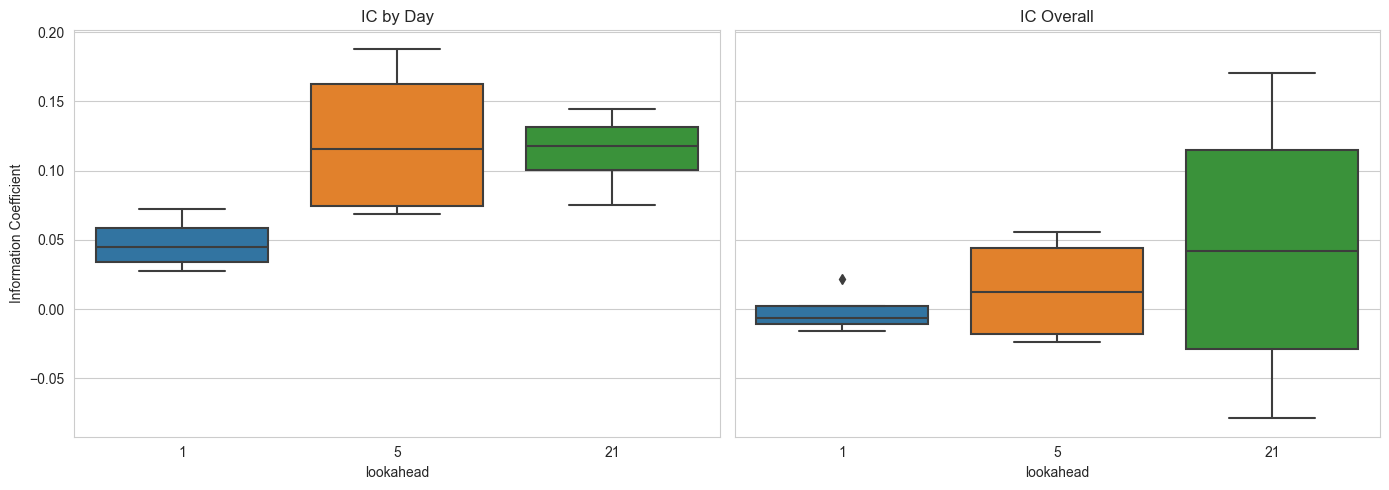

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5), sharey=True)

# plot average of daily IC values
sns.boxplot(x='lookahead', y='ic_by_day',data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Day')

# plot IC across all predictions
sns.boxplot(x='lookahead', y='ic',data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
fig.tight_layout()

## Best Train/Test Period Lengths

In [17]:
(lr_metrics.groupby('lookahead', group_keys=False)).apply(lambda x: x.nlargest(3, 'ic_by_day'))

,lookahead,train_length,test_length,ic_by_day,ic
3,1,252,21,0.072379,-0.008872
1,1,1134,21,0.054177,-0.004539
2,1,252,63,0.036155,-0.016102
7,5,252,21,0.188063,-0.023761
5,5,1134,21,0.154049,-0.016191
4,5,1134,63,0.076586,0.055433
9,21,1134,21,0.144815,-0.012465
11,21,252,21,0.127005,-0.078900
8,21,1134,63,0.108506,0.096060


In [18]:
lr_metrics.to_csv(results_path / 'lin_reg_metrics.csv', index=False)

In [19]:
def get_fi(model):
    """Return normalized feature importance as pd.Series"""
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                     index=model.feature_name()))

In [20]:
base_params = dict(boosting='gbdt',
                  objective='regression',
                  verbose=-1)

In [21]:
# constraints on structure (depth) of each tree
max_depths = [2, 3, 5, 7]
num_leaves_opts = [2 ** i for i in max_depths]
min_data_in_leaf_opts = [250, 500, 1000]

# weight of each new tree in the ensemble
learning_rate_ops = [.01, .1, .3]

# random feature selection
feature_fraction_opts = [.3, .6, .95]

In [22]:
param_names = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']

In [23]:
cv_params = list(product(learning_rate_ops,
                        num_leaves_opts,
                        feature_fraction_opts,
                        min_data_in_leaf_opts))
n_params = len(cv_params)
print(f'# Parameters: {n_params}')

# Parameters: 108


## Train/Test Period Lengths

In [24]:
lookaheads = [1, 5, 21]
label_dict = dict(zip(lookaheads, labels))

In [25]:
train_lengths = [int(4.5 * 252), 252]
test_lengths = [63]

In [26]:
test_params = list(product(lookaheads, train_lengths, test_lengths))
n = len(test_params)
test_param_sample = np.random.choice(list(range(n)), size=int(n), replace=False)
test_params = [test_params[i] for i in test_param_sample]
print('Train configs:', len(test_params))

Train configs: 6


In [27]:
categoricals = ['year', 'weekday', 'month']
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

In [28]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

In [29]:
lgb_store = Path(results_path / 'tuning_lgb.h5')

In [30]:
labels = sorted(data.filter(like='fwd').columns)
features = data.columns.difference(labels).tolist()

In [31]:
label_dict = dict(zip(lookaheads, labels))

In [32]:
num_iterations = [10, 25, 50, 75] + list(range(100, 501, 50))
num_boost_round = num_iterations[-1]

In [33]:
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] +
               [str(n) for n in num_iterations])

In [34]:
for lookahead, train_length, test_length in test_params:
    # randomized grid search
    cvp = np.random.choice(list(range(n_params)),
                           size=int(n_params / 2),
                           replace=False)
    cv_params_ = [cv_params[i] for i in cvp]

    # set up cross-validation
    n_splits = int(2 * YEAR / test_length)
    print(f'Lookahead: {lookahead:2.0f} | '
          f'Train: {train_length:3.0f} | '
          f'Test: {test_length:2.0f} | '
          f'Params: {len(cv_params_):3.0f} | '
          f'Train configs: {len(test_params)}')

    # time-series cross-validation
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              lookahead=lookahead,
                              test_period_length=test_length,
                              train_period_length=train_length)

    label = label_dict[lookahead]
    outcome_data = data.loc[:, features + [label]].dropna()
    
    # binary dataset
    lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1),
                           label=outcome_data[label],
                           categorical_feature=categoricals,
                           free_raw_data=False)
    T = 0
    predictions, metrics, feature_importance, daily_ic = [], [], [], []
    
    # iterate over (shuffled) hyperparameter combinations
    for p, param_vals in enumerate(cv_params_):
        key = f'{lookahead}/{train_length}/{test_length}/' + '/'.join([str(p) for p in param_vals])
        params = dict(zip(param_names, param_vals))
        params.update(base_params)

        start = time()
        cv_preds, nrounds = [], []
        ic_cv = defaultdict(list)
        
        # iterate over folds
        for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
            
            # select train subset
            lgb_train = lgb_data.subset(used_indices=train_idx.tolist(),
                                       params=params).construct()
            
            # train model for num_boost_round
            model = lgb.train(params=params,
                              train_set=lgb_train,
                              num_boost_round=num_boost_round,
                              verbose_eval=False)
            # log feature importance
            if i == 0:
                fi = get_fi(model).to_frame()
            else:
                fi[i] = get_fi(model)

            # capture predictions
            test_set = outcome_data.iloc[test_idx, :]
            X_test = test_set.loc[:, model.feature_name()]
            y_test = test_set.loc[:, label]
            y_pred = {str(n): model.predict(X_test, num_iteration=n) for n in num_iterations}
            
            # record predictions for each fold
            cv_preds.append(y_test.to_frame('y_test').assign(**y_pred).assign(i=i))
        
        # combine fold results
        cv_preds = pd.concat(cv_preds).assign(**params)
        predictions.append(cv_preds)
        
        # compute IC per day
        by_day = cv_preds.groupby(level='date')
        ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                               for n in num_iterations], axis=1)
        daily_ic_mean = ic_by_day.mean()
        daily_ic_mean_n = daily_ic_mean.idxmax()
        daily_ic_median = ic_by_day.median()
        daily_ic_median_n = daily_ic_median.idxmax()
        
        # compute IC across all predictions
        ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0] for n in num_iterations]
        t = time() - start
        T += t
        
        # collect metrics
        metrics = pd.Series(list(param_vals) +
                            [t, daily_ic_mean.max(), daily_ic_mean_n, daily_ic_median.max(), daily_ic_median_n] + ic,
                            index=metric_cols)
        msg = f'\t{p:3.0f} | {format_time(T)} ({t:3.0f}) | {params["learning_rate"]:5.2f} | '
        msg += f'{params["num_leaves"]:3.0f} | {params["feature_fraction"]:3.0%} | {params["min_data_in_leaf"]:4.0f} | '
        msg += f' {max(ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {daily_ic_mean_n: 4.0f} | {ic_by_day.median().max(): 6.2%} | {daily_ic_median_n: 4.0f}'
        print(msg)

        # persist results for given CV run and hyperparameter combination
        metrics.to_hdf(lgb_store, 'metrics/' + key)
        ic_by_day.assign(**params).to_hdf(lgb_store, 'daily_ic/' + key)
        fi.T.describe().T.assign(**params).to_hdf(lgb_store, 'fi/' + key)
        cv_preds.to_hdf(lgb_store, 'predictions/' + key)

Lookahead:  1 | Train: 1134 | Test: 63 | Params:  54 | Train configs: 6
	  0 | 00:01:22 ( 82) |  0.30 |   4 | 95% | 1000 |   2.77% |  1.53% |  350 |  1.61% |  200
	  1 | 00:02:32 ( 70) |  0.01 |   4 | 60% |  500 |   1.55% |  0.64% |   75 |  0.75% |  150
	  2 | 00:03:43 ( 70) |  0.10 |   4 | 60% |  500 |   2.88% |  1.87% |  500 |  1.88% |  300
	  3 | 00:06:08 (145) |  0.10 | 128 | 95% |  250 |   3.36% |  1.98% |  350 |  2.27% |  350
	  4 | 00:07:09 ( 60) |  0.01 |   8 | 30% |  500 |   1.13% |  1.17% |  500 |  1.30% |  450
	  5 | 00:08:07 ( 58) |  0.10 |   8 | 30% |  250 |   2.73% |  1.91% |  500 |  1.87% |  450
	  6 | 00:10:40 (153) |  0.10 | 128 | 95% |  500 |   3.45% |  1.97% |  150 |  1.82% |  100
	  7 | 00:12:44 (124) |  0.10 | 128 | 60% |  250 |   3.44% |  1.80% |  300 |  1.65% |  150
	  8 | 00:13:42 ( 58) |  0.10 |   8 | 30% | 1000 |   2.39% |  1.51% |  200 |  1.23% |  450
	  9 | 00:14:45 ( 63) |  0.01 |   8 | 30% | 1000 |   1.47% |  1.19% |  500 |  1.39% |  450
	 10 | 00:16:29 (1

KeyboardInterrupt: 